# KNN для предсказания `outcome`

Датасет: `dataset/horse.csv`. В ноутбуке:
- Загрузка и первичный осмотр данных
- Препроцессинг признаков (пропуски, кодирование категорий)
- Обучение KNN и подбор числа соседей
- Оценка качества на тесте



In [294]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score,
)

pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")

In [295]:
path = "dataset/horse.csv"
df = pd.read_csv(path)
print(df.shape)
df.head()

(299, 28)


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


In [296]:
missing_pct = df.isna().mean().sort_values(ascending=False)
missing_pct

nasogastric_reflux_ph    0.822742
abdomo_protein           0.662207
abdomo_appearance        0.551839
abdomen                  0.394649
nasogastric_reflux       0.354515
nasogastric_tube         0.347826
rectal_exam_feces        0.341137
peripheral_pulse         0.230769
rectal_temp              0.200669
respiratory_rate         0.193980
abdominal_distention     0.187291
temp_of_extremities      0.187291
pain                     0.183946
mucous_membrane          0.157191
peristalsis              0.147157
total_protein            0.110368
capillary_refill_time    0.107023
packed_cell_volume       0.096990
pulse                    0.080268
hospital_number          0.000000
age                      0.000000
surgery                  0.000000
outcome                  0.000000
surgical_lesion          0.000000
lesion_1                 0.000000
lesion_2                 0.000000
lesion_3                 0.000000
cp_data                  0.000000
dtype: float64

In [ ]:
df["outcome"].value_counts()

outcome
lived         178
died           77
euthanized     44
Name: count, dtype: int64


#### Визуализация распределения классов и пропусков



#### Доп. разведка числовых признаков по классам
Посмотрим распределения основных числовых показателей по `outcome`.

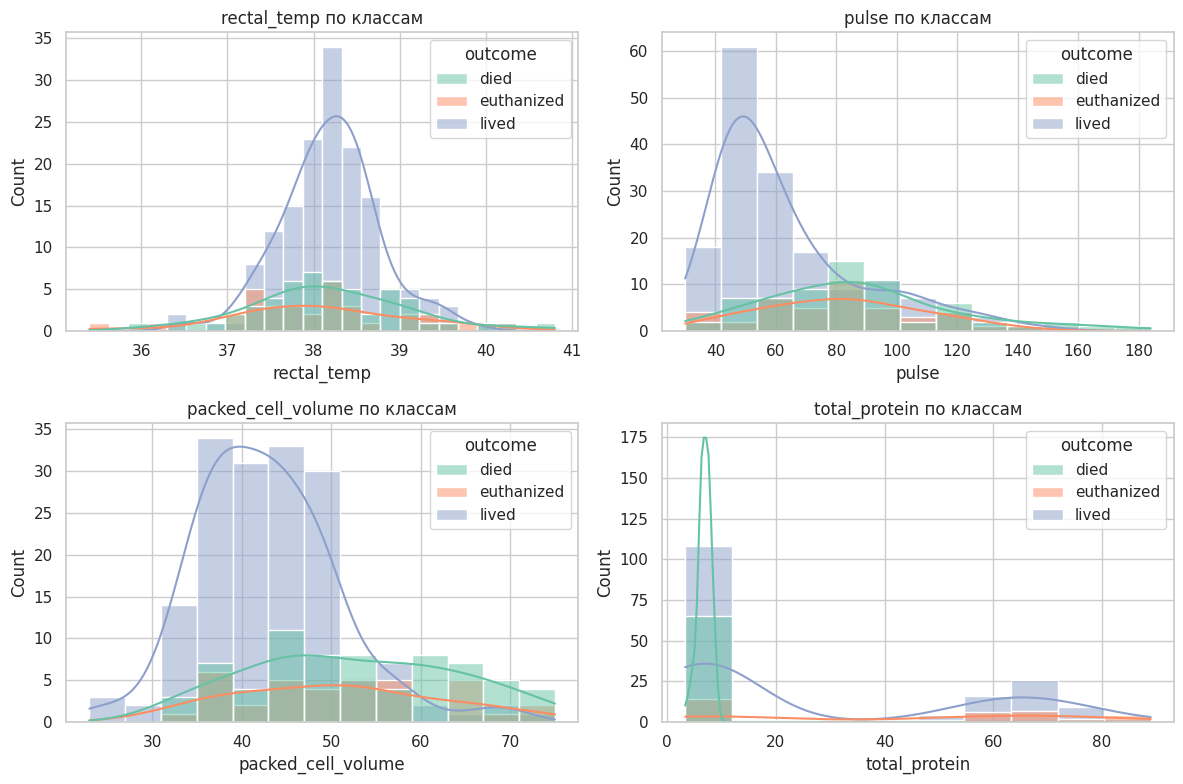

In [298]:
num_to_plot = ["rectal_temp", "pulse", "packed_cell_volume", "total_protein"]
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for col, ax in zip(num_to_plot, axes.ravel()):
    sns.histplot(data=df, x=col, hue="outcome", kde=True, ax=ax, palette="Set2")
    ax.set_title(f"{col} по классам")
plt.tight_layout()
plt.show()

#### Частоты категориальных признаков
Выберем самые информативные по смыслу: боль (`pain`) и перистальтика (`peristalsis`).

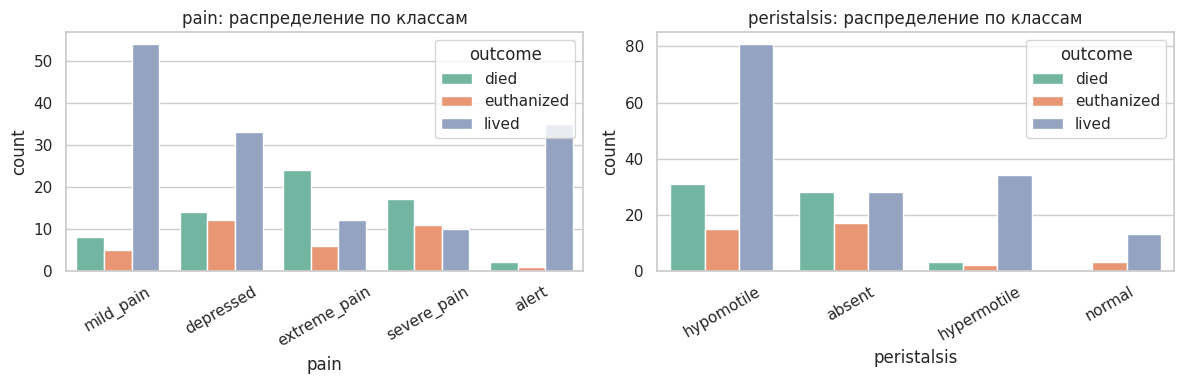

In [299]:
cat_to_plot = ["pain", "peristalsis"]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for col, ax in zip(cat_to_plot, axes):
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, hue="outcome", order=order, ax=ax, palette="Set2")
    ax.set_title(f"{col}: распределение по классам")
    ax.set_xlabel(col)
    ax.set_ylabel("count")
    ax.tick_params(axis="x", rotation=30)
plt.tight_layout()
plt.show()

#### Корреляции числовых признаков
Корреляционная матрица по числовым столбцам (импутация медианой для простоты просмотра).

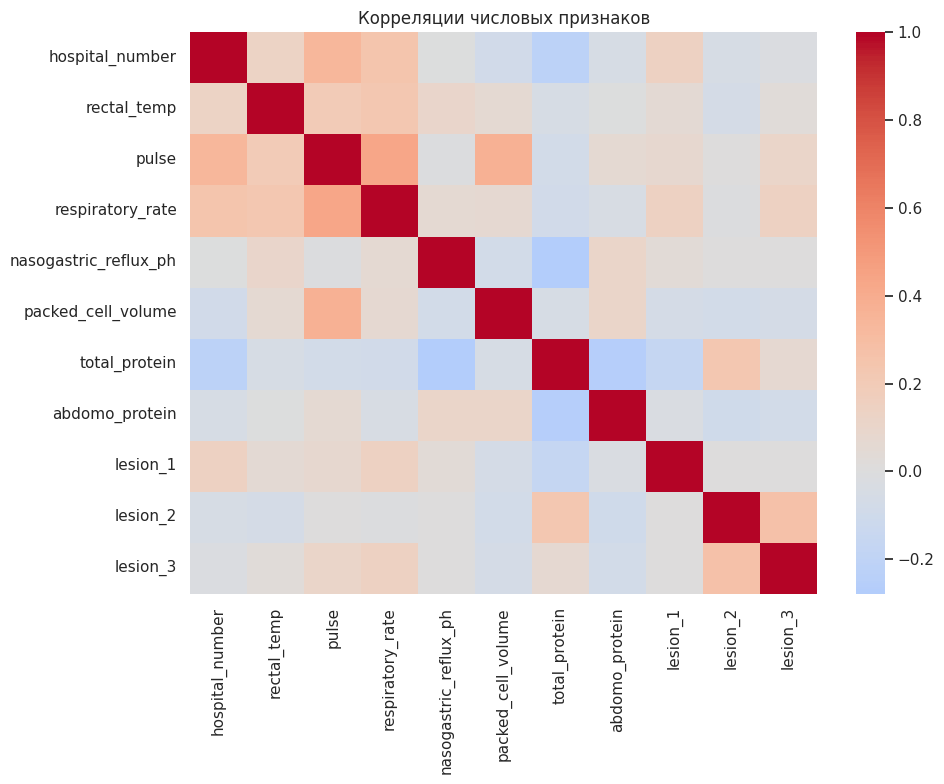

In [300]:
num_df = df.select_dtypes(include=["number"])
num_df_imputed = num_df.fillna(num_df.median())
plt.figure(figsize=(10, 8))
sns.heatmap(num_df_imputed.corr(), cmap="coolwarm", center=0)
plt.title("Корреляции числовых признаков")
plt.tight_layout()
plt.show()

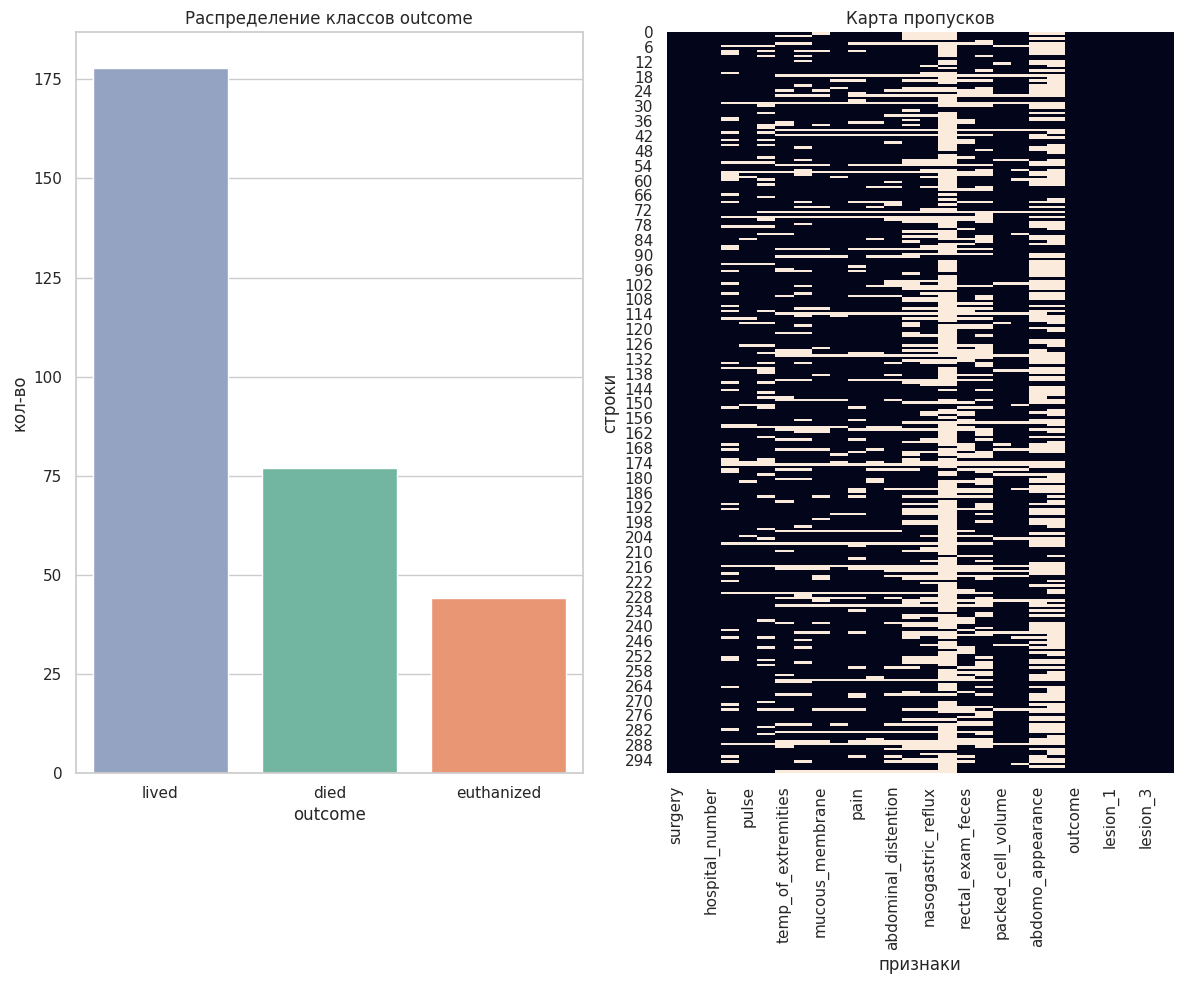

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10))

target = df["outcome"]
sns.countplot(
    x=target,
    order=target.value_counts().index,
    ax=axes[0],
    palette="Set2",
    hue=target,
    legend=False,
)
axes[0].set_title("Распределение классов outcome")
axes[0].set_xlabel("outcome")
axes[0].set_ylabel("кол-во")

sns.heatmap(df.isna(), cbar=False, ax=axes[1])
axes[1].set_title("Карта пропусков")
axes[1].set_xlabel("признаки")
axes[1].set_ylabel("строки")

plt.tight_layout()
plt.show()


### Разделение на признаки/цель и подготовка колонок

In [302]:
X = df.drop(columns=["outcome"])
y = df["outcome"]

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

numeric_pipe = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    [("num", numeric_pipe, num_cols), ("cat", categorical_pipe, cat_cols)]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## Бейзлайн: KNN без подбора гиперпараметров

In [303]:
knn_base = KNeighborsClassifier(n_neighbors=10, weights="uniform")
model_base = Pipeline([("preprocess", preprocess), ("clf", knn_base)])
model_base.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



### Оценка бейзлайна на тестовой выборке

In [304]:
y_pred = model_base.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5166666666666667

Classification report:
               precision    recall  f1-score   support

        died       0.40      0.53      0.46        15
  euthanized       0.00      0.00      0.00         9
       lived       0.64      0.64      0.64        36

    accuracy                           0.52        60
   macro avg       0.35      0.39      0.37        60
weighted avg       0.48      0.52      0.50        60




### Тепловая карта confusion matrix (бейзлайн)

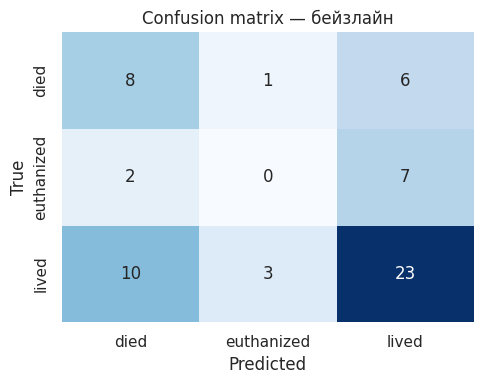

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=model_base.classes_)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=model_base.classes_,
    yticklabels=model_base.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — бейзлайн")
plt.tight_layout()
plt.show()

## Улучшение бейзлайна

Гипотезы:
- Удалить признаки с экстремальным числом пропусков
- Сделать gridsearch с подбором `n_neighbors` и по метрике `f1_macro`
- Сохранить distance-weighting, чтобы соседи ближе влияли сильнее

Подготовка улучшенного датасета — выбрасываем признаки с долей пропусков выше порога (задаём константу), затем собираем новые списки числовых/категориальных колонок

In [306]:
missing_thresh = 0.7
missing_pct = df.isna().mean()
high_na_cols = missing_pct[missing_pct > missing_thresh].index.tolist()
print("Колонки, удалённые по порогу пропусков:", high_na_cols)

df_imp = df.drop(columns=high_na_cols)

X_imp = df_imp.drop(columns=["outcome"])
y_imp = df_imp["outcome"]

cat_cols_imp = X_imp.select_dtypes(include=["object"]).columns.tolist()
num_cols_imp = [c for c in X_imp.columns if c not in cat_cols_imp]

numeric_pipe_imp = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_pipe_imp = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess_imp = ColumnTransformer(
    [
        ("num", numeric_pipe_imp, num_cols_imp),
        ("cat", categorical_pipe_imp, cat_cols_imp),
    ]
)

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imp, y_imp, test_size=0.2, random_state=42, stratify=y_imp
)

Колонки, удалённые по порогу пропусков: ['nasogastric_reflux_ph']


Подбор KNN по метрике `f1_macro` на расширенной сетке параметров, чтобы учитывать дисбаланс классов.


In [ ]:
knn_imp = KNeighborsClassifier()
model_imp = Pipeline([("preprocess", preprocess_imp), ("clf", knn_imp)])

param_grid_imp = {
    "clf__n_neighbors": [3, 4, 5, 7, 9, 11, 13],
    "clf__weights": ["uniform", "distance"],
}

gs_imp = GridSearchCV(
    model_imp, param_grid_imp, cv=5, scoring="f1_macro", n_jobs=-1, verbose=0
)
gs_imp.fit(X_train_imp, y_train_imp)

print("Лучший f1_macro CV:", gs_imp.best_score_)
print("Лучшие параметры:", gs_imp.best_params_)

Лучший f1_macro CV: 0.5599584238196161
Лучшие параметры: {'clf__n_neighbors': 4, 'clf__weights': 'distance'}


Оценка улучшенного бейзлайна на тесте и сравнение с начальной моделью.

In [308]:
best_model_imp = gs_imp.best_estimator_
y_pred_imp = best_model_imp.predict(X_test_imp)

acc_imp = accuracy_score(y_test_imp, y_pred_imp)
f1_imp = f1_score(y_test_imp, y_pred_imp, average="macro")

print("Accuracy:", acc_imp)
print("F1-macro:", f1_imp)
print("\nClassification report:\n", classification_report(y_test_imp, y_pred_imp))

Accuracy: 0.65
F1-macro: 0.5589247905735064

Classification report:
               precision    recall  f1-score   support

        died       0.63      0.80      0.71        15
  euthanized       0.33      0.22      0.27         9
       lived       0.71      0.69      0.70        36

    accuracy                           0.65        60
   macro avg       0.56      0.57      0.56        60
weighted avg       0.64      0.65      0.64        60



**Тепловая карта CV (улучшенный бейзлайн)** — визуализируем `f1_macro` для разных `n_neighbors` и `weights`.

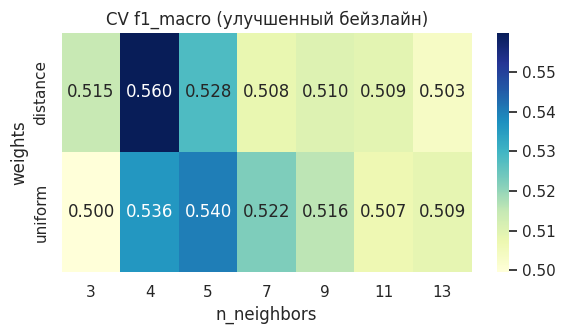

In [ ]:
cv_res_imp = pd.DataFrame(gs_imp.cv_results_)
pivot_imp = cv_res_imp.pivot_table(
    index="param_clf__weights",
    columns="param_clf__n_neighbors",
    values="mean_test_score",
)
fig, ax = plt.subplots(figsize=(6, 3.5))
sns.heatmap(pivot_imp, annot=True, fmt=".3f", cmap="YlGnBu", ax=ax)
ax.set_title("CV f1_macro (улучшенный бейзлайн)")
ax.set_xlabel("n_neighbors")
ax.set_ylabel("weights")
plt.tight_layout()
plt.show()

Тепловая карта confusion matrix (улучшенный бейзлайн)

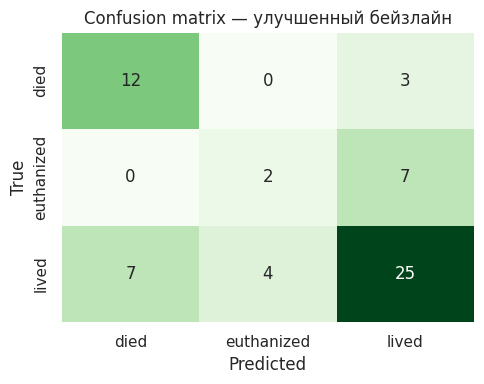

In [ ]:
best_model_imp_cm = gs_imp.best_estimator_
y_pred_imp_cm = best_model_imp_cm.predict(X_test_imp)
cm_imp = confusion_matrix(y_test_imp, y_pred_imp_cm, labels=gs_imp.classes_)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(
    cm_imp,
    annot=True,
    fmt="d",
    cmap="Greens",
    cbar=False,
    xticklabels=gs_imp.classes_,
    yticklabels=gs_imp.classes_,
    ax=ax,
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion matrix — улучшенный бейзлайн")
plt.tight_layout()
plt.show()